# Regression neural network that generates a large amount of distributions and trains to deconvolute them.

Written by Simos Kalfas
email: simos.kalfas@gmail.com
github: www.github.com/simoskalfas

In [2]:
import numpy as np

In [3]:
class Normal_Distribution:
    """A Gaussian peak with five properties.
    
    After definition, all attributes can be accessed separately.
    
    Attributes:
        mean: The mean of the Gaussian
        std: The standard deviation of the Gaussian
        height: The height (scale) of the Gaussian
        x: The x value series (timeseries)
        data: The y values (intensities)
    """
    def __init__(self,mean,std,height,x):
        """Initialises the Normal_distribution object.
        """
        self.initialize_variables(mean,std,height,x)
        self.create_distribution()
    def initialize_variables(self,mean,std,height,x):
        """Initializes the attributes.
        """
        self.mean = mean
        self.std = std
        self.x = x
        self.height = height
        self.data = np.array([])
    def create_distribution(self):
        """Generates the Gaussian peak (intensities).
        """
        self.data = self.height * np.exp(-((self.x - self.mean) ** 2) / (2 * (self.std ** 2)))

In [4]:
class Combine_Distribution:
    """Combines several Normal_distribution objects (Gaussian peaks) into a 
    mixture distribution.
    
    Deconvoluting this type of distribution is the aim of this model.
    
    Attributes:
        distribution: The constituent Gaussian peaks.
        curve: The combined distribution intensity series.
    """
    def __init__(self, distributions):
        """Initialises the Combine_Distribution object
        """
        self.initialize_variables(distributions)
        self.combine()
        
    def initialize_variables(self, distributions):
        """Initialises the attributes of the object.
        """
        self.distributions = distributions
        self.curve = np.zeros(len(self.distributions[0].data))
        
    def combine(self):
        """Generates the combined distribution (curve).
        """
        for i in self.distributions:
            self.curve = [sum(x) for x in list(zip(self.curve,i.data))]

In [5]:
class Create_Dataset:
    """Generate a random dataset of several distribution curves for training 
    and cross-evaluation.
    
    Attributes:
        x: The time series (x values).
        sample_number: The given number of distributions to be generated.
        number_of_gaussians: Randomly generated number of Gaussian peaks
            to be convoluted for each combined distribution (currently 
            between 1 and 4).
        name_dictionary: Dict containing all Gaussian peaks for each 
            combined distribution.
        mean: Mean of the current Gaussian peak generated.
        std: Standard deviation of the current Gaussian peak generated.
        height: Height (scale) of the current Gaussian peak generated.
        features: The combined distributions of the data set
        targets: The Gaussian peaks that were combined for each distribution.
        means_array: All the taget means for a combined distribution.
        std_array: All the taget standard deviations for a combined distribution.
        height_array: All the taget heights for a combined distribution.
    """
    def __init__(self,x,sample_number):
        """Initialises the Create_Dataset object.
        """
        self.initialize_variables(x,sample_number)
        self.create_samples()
    def initialize_variables(self,x,sample_number): 
        """Initialises the attributes of the Create_Dataset object.
        """
        self.x = x
        self.sample_number = sample_number
        self.number_of_gaussians = 0
        self.name_dictionary = {}
        self.mean = 0
        self.std = 0
        self.height = 0 
        self.features = []
        self.targets = []
        self.means_array = np.zeros(10)
        self.std_array = np.zeros(10)
        self.height_array = np.zeros(10)
    def create_samples(self):
        """Generates the dataset as per the given specifications and the bounds 
        of the random generators throughout.
        """
        for _ in range(0,self.sample_number):
            self.number_of_gaussians = np.random.randint(1,4)
            #self.number_of_gaussians = 1
            for i in range(0,self.number_of_gaussians):
                if self.means_array[i - 1] != 0:
                    prev_mean = self.means_array[i - 1]
                    self.mean = prev_mean + np.round(2+(max(self.x) - 5 - prev_mean + 2)*np.random.random_sample(), 2)
                    self.means_array[i] = self.mean
                else:
                    self.mean = np.round(40*np.random.random_sample(), 2)
                    self.means_array[i] = self.mean
                self.std = np.round(4*np.random.random_sample(), 2)
                self.std_array[i] = self.std
                self.height = np.round(np.random.random_sample(), 2)
                self.height_array[i] = self.height
                self.name_dictionary['distibution' + str(i)] = Normal_Distribution(self.mean,self.std,self.height,self.x)
            self.features.append(Combine_Distribution([self.name_dictionary[i].data for i in self.name_dictionary]).curve)
            self.targets.append(np.array([self.means_array,self.std_array,self.height_array]).flatten())
            self.means_array = np.zeros(10)
            self.std_array = np.zeros(10)
            self.height_array = np.zeros(10)  
            self.name_dictionary = {}
            

Creates timeseries

In [6]:
x_range = np.linspace(0, 40, 200)

Generates dataset

In [7]:
Dataset = Create_Dataset(x_range, 300000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Splits the dataset between training and evaluation data.

In [8]:
from sklearn.model_selection import train_test_split
train_x , test_x , train_y , test_y = train_test_split(Dataset.features,Dataset.targets,test_size = 0.25)

In [9]:
np.array(train_x).shape

(225000, 200)

In [10]:
from keras import *
from keras.layers import Dense

Using TensorFlow backend.


# Creates the neural network and trains it. A three layer network was used here which, after rudimentary tuning of the hyperparameters, only shows convergence when a very large dataset is used. A more complex architecture should be considered.

In [11]:
model = Sequential()
model.add(Dense(300, input_shape=(200,), activation='relu'))
model.add(Dense(400, input_shape=(300,), activation='relu'))
model.add(Dense(30, input_shape=(400,)))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(np.array(train_x), np.array(train_y), epochs=60, validation_split=0.1, batch_size=100)

Train on 202500 samples, validate on 22500 samples
Epoch 1/60
202500/202500 [==============================] - 9s 47us/step - loss: 10.6009 - val_loss: 8.8042
Epoch 2/60
202500/202500 [==============================] - 9s 44us/step - loss: 8.3439 - val_loss: 7.7820
Epoch 3/60
202500/202500 [==============================] - 9s 43us/step - loss: 7.5993 - val_loss: 7.3204
Epoch 4/60
202500/202500 [==============================] - 9s 44us/step - loss: 7.1566 - val_loss: 6.9928
Epoch 5/60
202500/202500 [==============================] - 9s 44us/step - loss: 6.8508 - val_loss: 6.9067
Epoch 6/60
202500/202500 [==============================] - 9s 43us/step - loss: 6.6548 - val_loss: 6.7165
Epoch 7/60
202500/202500 [==============================] - 9s 44us/step - loss: 6.4877 - val_loss: 6.7141
Epoch 8/60
202500/202500 [==============================] - 9s 44us/step - loss: 6.3449 - val_loss: 6.3802
Epoch 9/60
202500/202500 [==============================] - 9s 43us/step - loss: 6.2002 - va

In [12]:
model.predict(np.array(test_x[0]).reshape(1,200))


array([[ 2.0744171e+01,  5.3539181e-01, -2.4453944e-01, -2.6224682e-04,
        -2.9664310e-03,  9.1890595e-04,  3.5969701e-05,  3.0539578e-03,
        -2.6657595e-03, -3.1518524e-03,  8.5353774e-01,  3.6455274e-02,
         5.3822339e-02, -1.2159459e-03, -1.8290926e-02,  1.1748450e-03,
        -1.3528594e-02, -7.1897539e-03, -7.0394911e-03, -7.0641167e-05,
         1.9889982e-01, -9.0451539e-04, -1.4649168e-02, -6.1315356e-04,
         1.8174032e-04,  2.7221900e-03,  4.4768833e-04,  4.1354569e-03,
        -2.9438181e-04, -1.4578330e-04]], dtype=float32)

In [13]:
test_y[5]

array([2.551e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.380e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e-02, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [14]:
from matplotlib import pyplot as plt

Plots randomly selected examples of fitted data for evaluation.

10


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


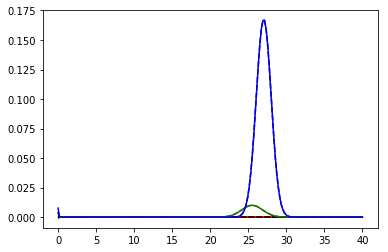

10


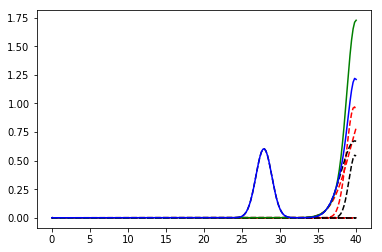

10


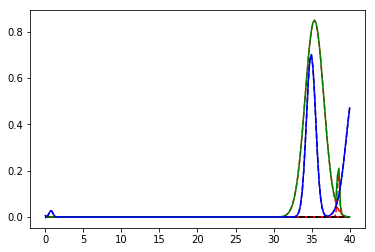

10


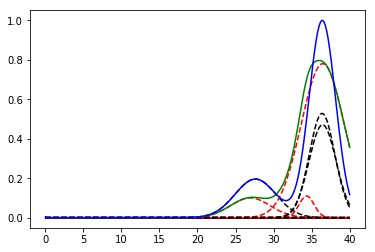

10


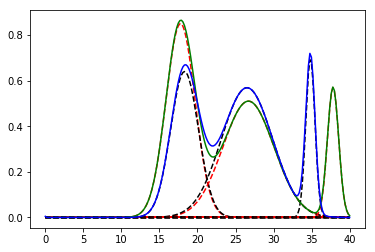

10


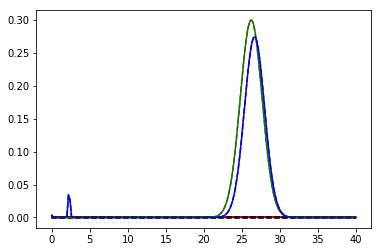

10


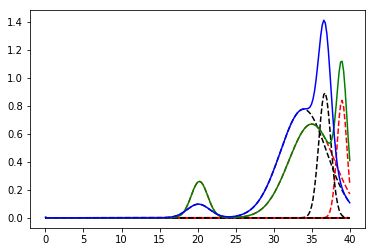

10


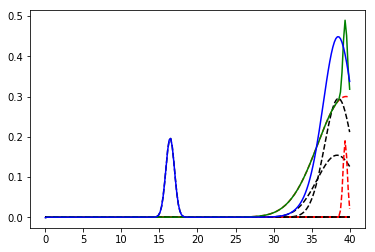

10


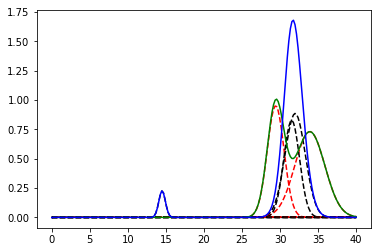

10


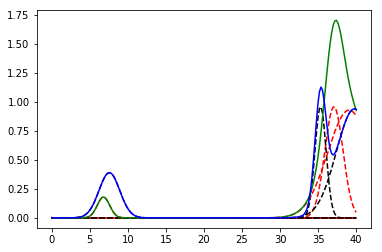

10


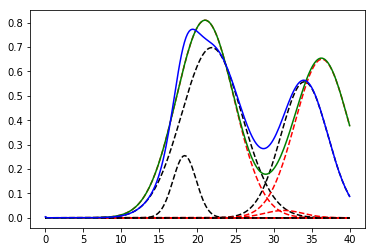

10


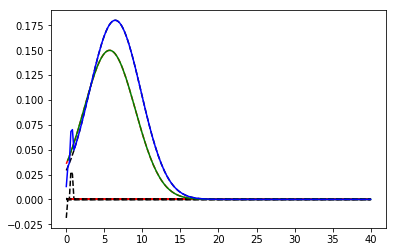

10


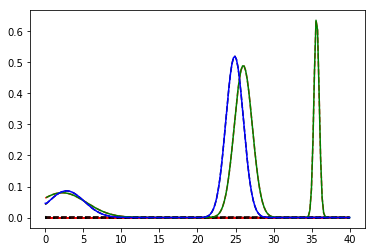

10


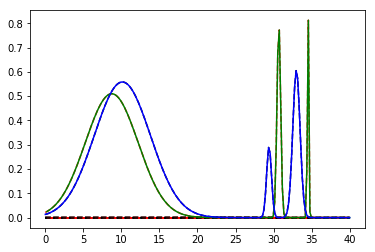

10


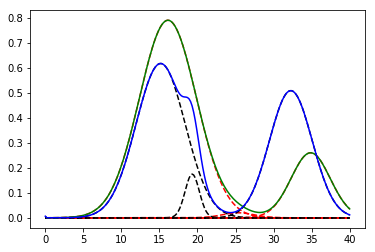

10


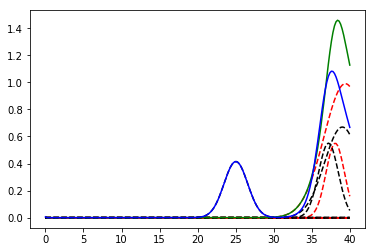

10


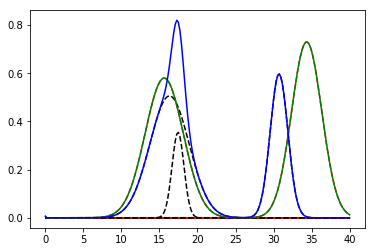

10


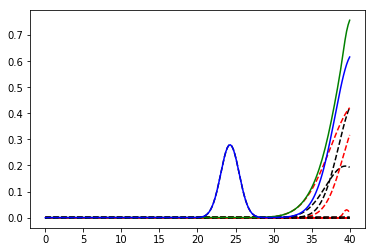

10


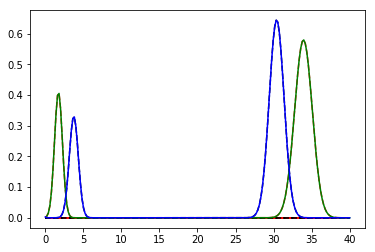

10


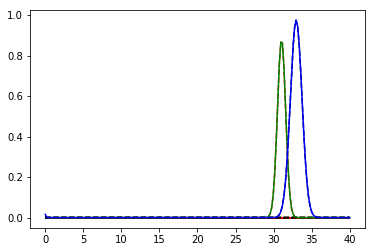

10


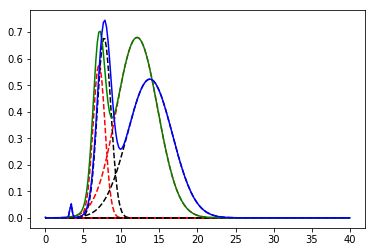

10


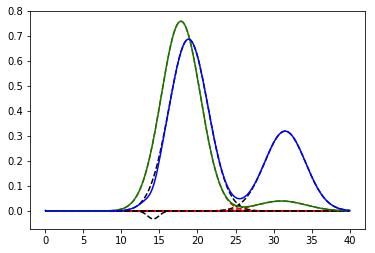

10


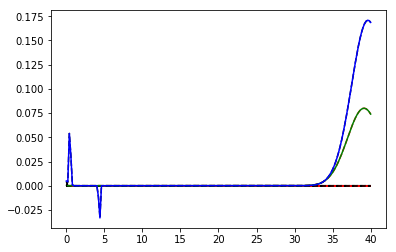

10


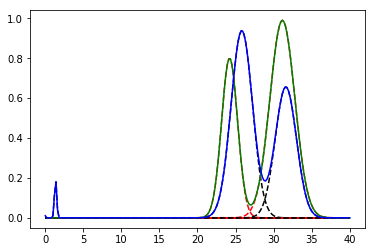

10


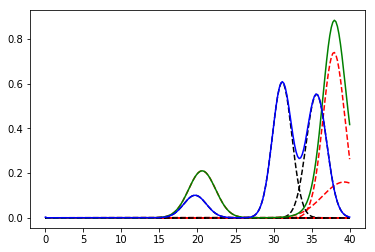

10


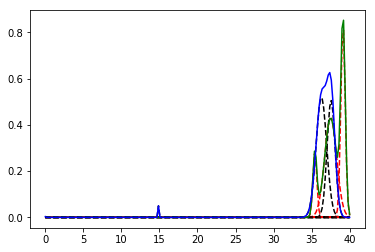

10


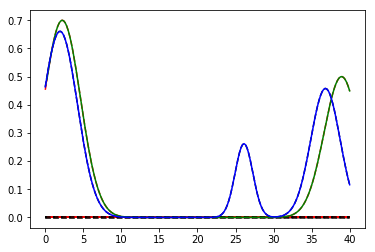

10


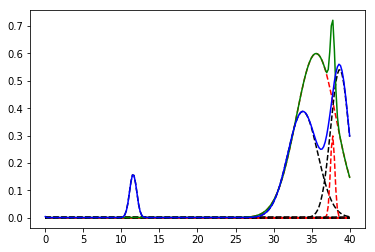

10


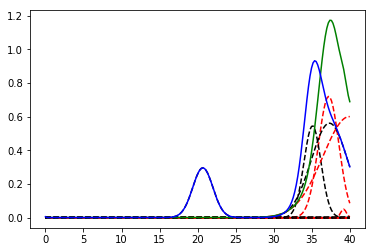

10


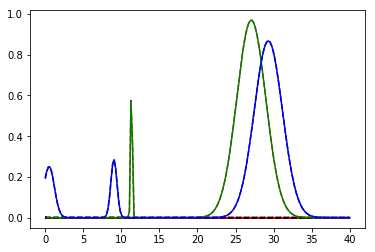

10


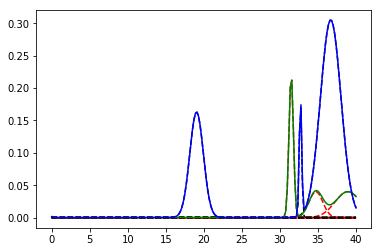

10


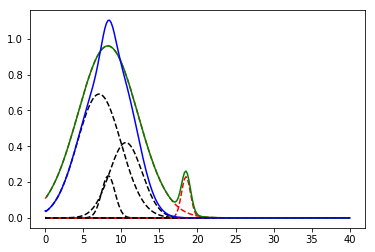

10


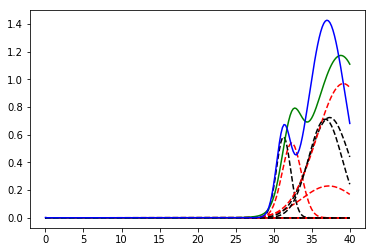

10


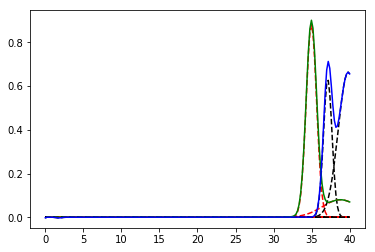

10


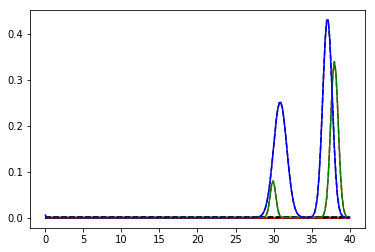

10


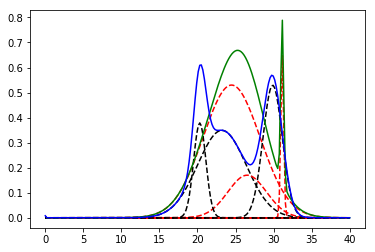

10


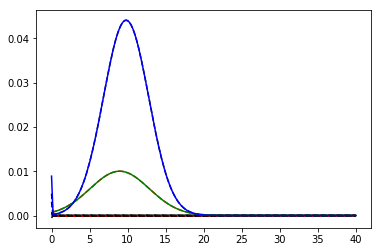

10


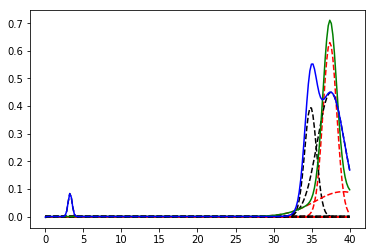

10


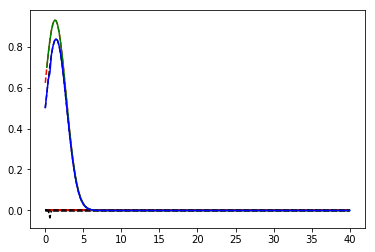

10


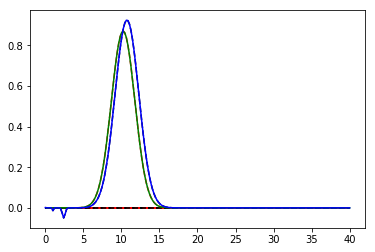

10


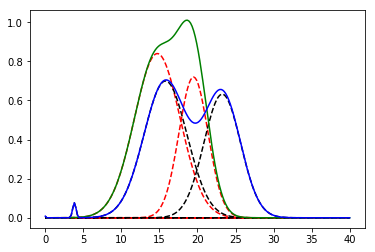

10


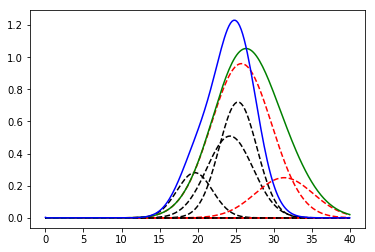

10


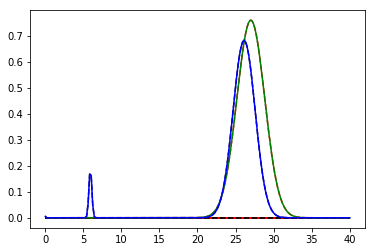

10


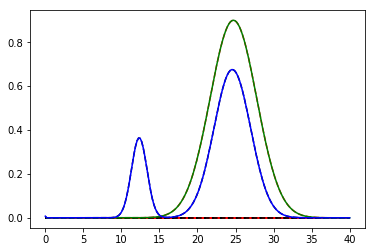

10


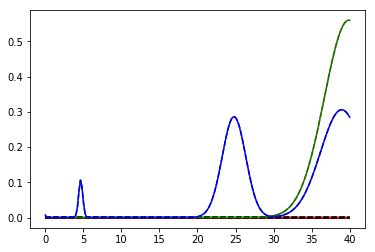

10


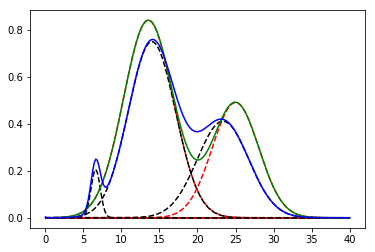

10


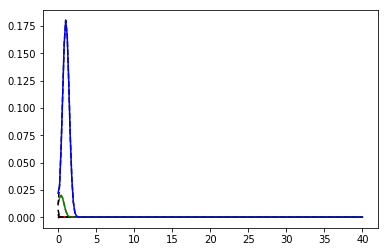

10


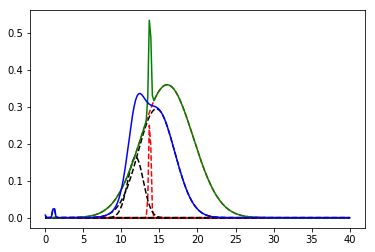

10


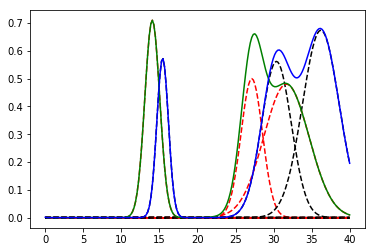

10


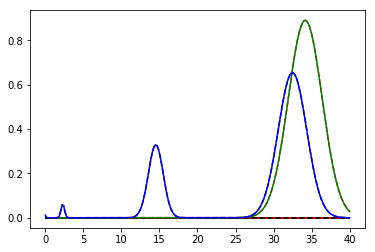

10


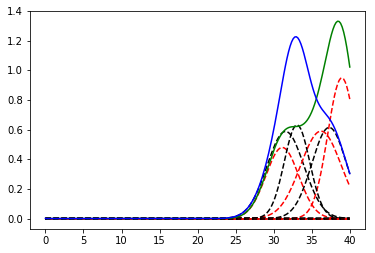

10


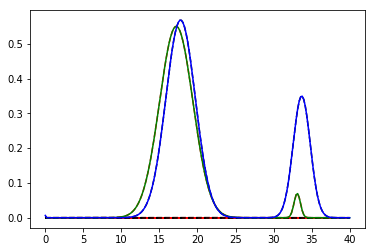

10


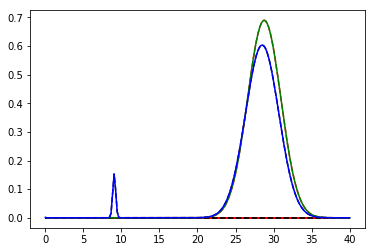

10


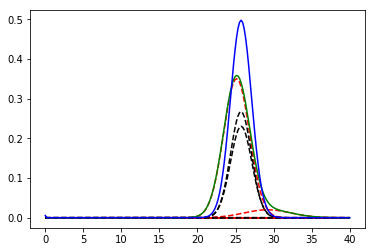

10


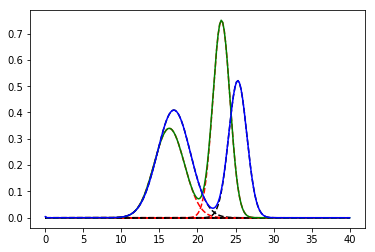

10


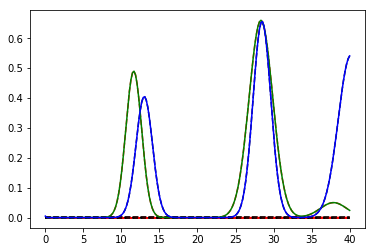

10


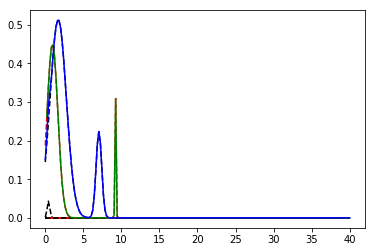

10


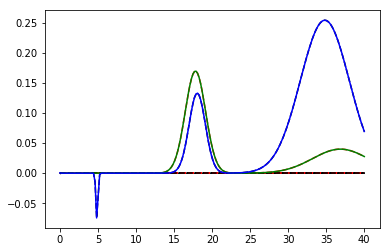

10


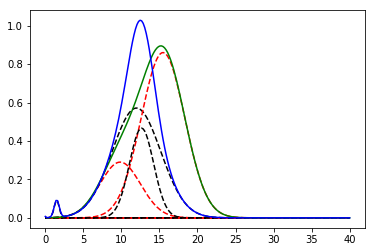

10


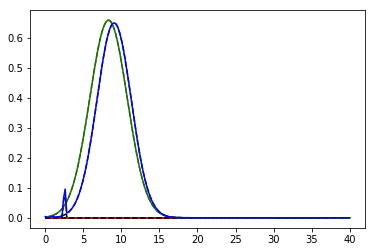

10


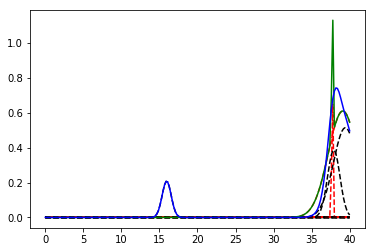

10


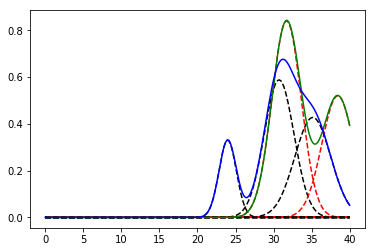

10


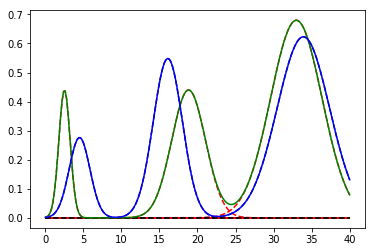

10


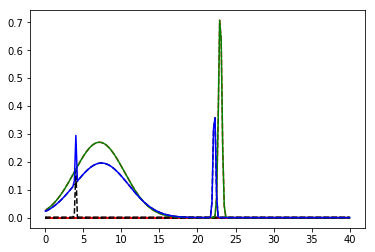

10


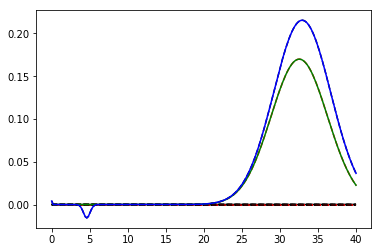

10


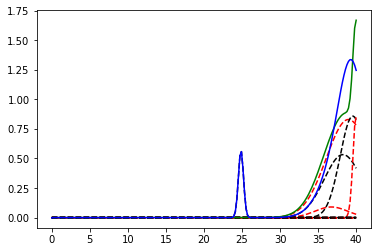

10


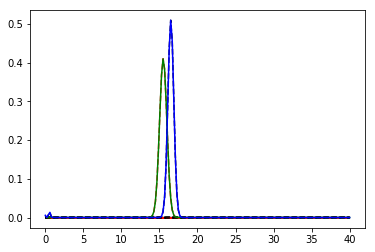

10


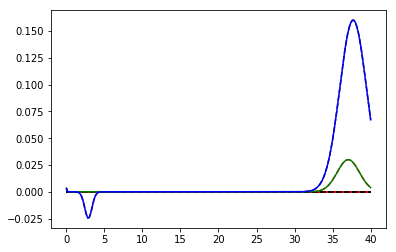

10


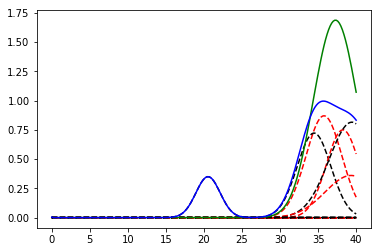

10


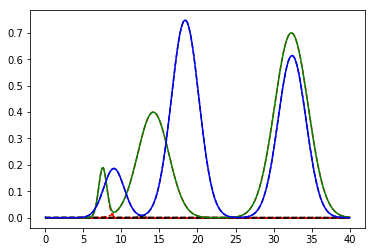

10


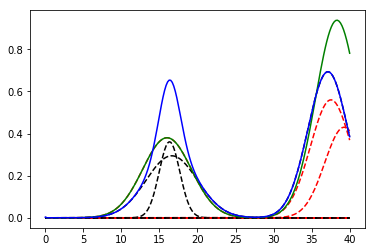

10


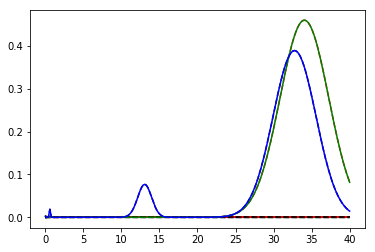

10


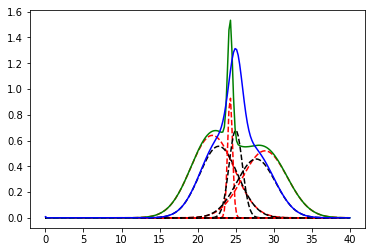

10


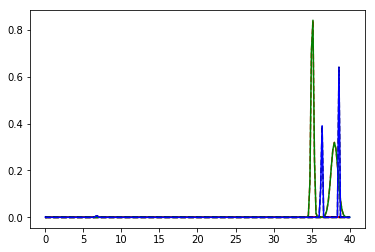

10


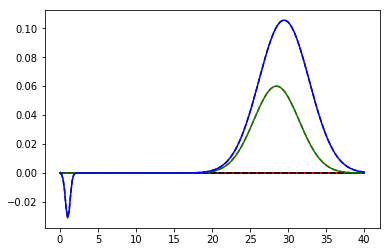

In [49]:

for i in range(5, len(test_y), 1000):
    gaussdic = {}
    testclean = []
    predclean = []
    for j in range(0,len(test_y[i])):
         #if test_y[i][j] != 0.:
        testclean.append(test_y[i][j])
        predclean.append(model.predict(np.array(test_x[i]).reshape(1,200))[0][j])
    num = int(len(testclean)/3)
    print(num)
    testcurve = Combine_Distribution([Normal_Distribution(testclean[j],testclean[j + num],testclean[j + 2*num], x_range)  for j in range(0, num)])
    predcurve = Combine_Distribution([Normal_Distribution(predclean[j],predclean[j + num],predclean[j + 2*num], x_range)  for j in range(0, num)])
    for j in range(0, len(testcurve.distributions)):
        plt.plot(np.linspace(0, 40, 200), testcurve.distributions[j].data, 'r--', label=str(i))
        plt.plot(np.linspace(0, 40, 200), predcurve.distributions[j].data, 'k--', label=str(i))
        #plt.legend()
    plt.plot(np.linspace(0, 40, 200), testcurve.curve, 'g')
    plt.plot(np.linspace(0, 40, 200), predcurve.curve, 'b')
    plt.show()
        

# Test using real data to evaluate. There is no detectable convergance meaning that the generated dataset is not representative.

In [21]:
def handle_file(filename, make_txt=False):
    datdic = {}
    with open('../Data/' + filename + '.txt', 'r') as f:
        fl = f.readline()
        fl = fl.replace('\r', '')
        fl = fl.replace('\n', '')
        fl = fl.split('\t')
        for i in fl:
            datdic[str(i)] = []
        for line in f:
            spl = line.replace('\r', '')
            spl = spl.replace('\n', '')
            spl = spl.split('\t')
            for j in range(len(spl)):
                datdic[fl[j]].append(float(spl[j]))
    if make_txt:
        with open('splitdata.txt', 'w') as f:
            for i in datdic:
                f.write(str(i))
                f.write(str(datdic[str(i)]))
                f.write('\n')
    return datdic

In [26]:
filename = 'mvar_run1_atd'
datadic = handle_file(filename)

[[ 9.2629066e+01 -4.6558691e+02  1.5825642e+03  1.6283140e-01
   1.6990025e-01  1.3792005e-01 -9.2432240e-04 -2.3994634e-01
   2.3167662e-02  6.3472950e-01 -4.3936916e+01  8.0010519e+00
   9.1678177e+01  1.4227501e+00  1.7629683e+00 -1.1177058e-01
   2.2642488e+00  3.7904611e-01  1.6155436e+00 -4.7200467e-03
   1.0657648e+01  3.0330692e+01  3.6543919e+01  1.0532308e-01
  -2.3187828e-01 -7.4339002e-02 -1.0077415e-01 -1.7114359e-01
   2.0454264e-01  5.5422518e-02]]


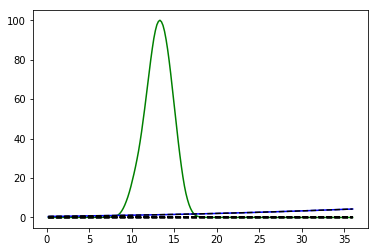

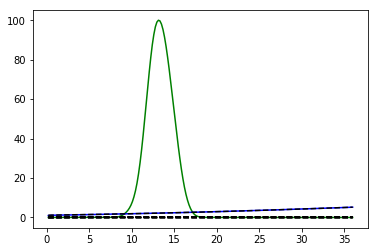

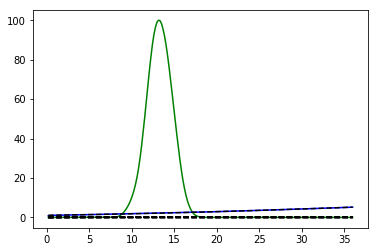

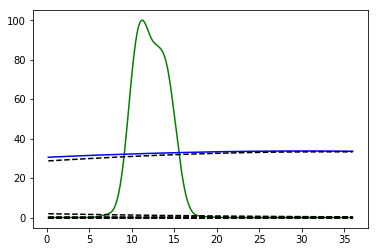

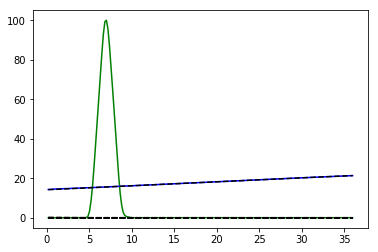

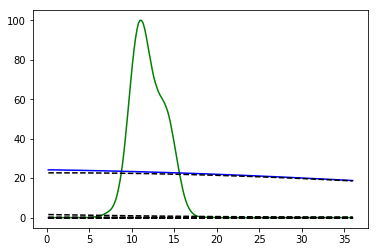

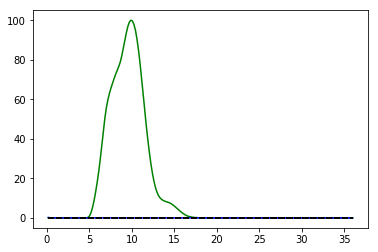

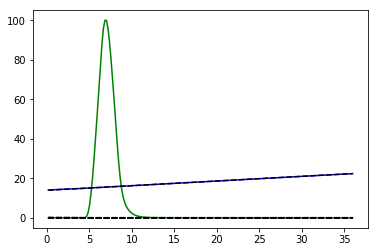

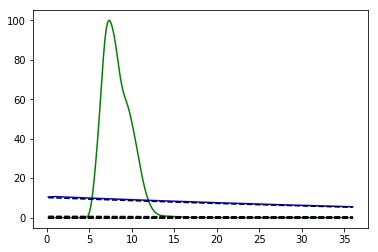

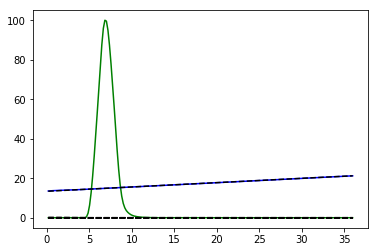

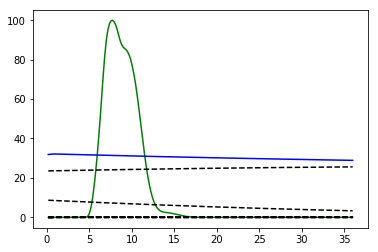

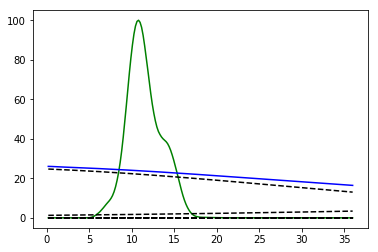

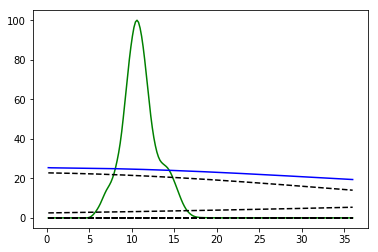

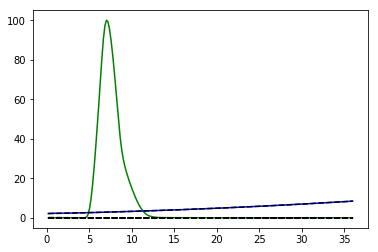

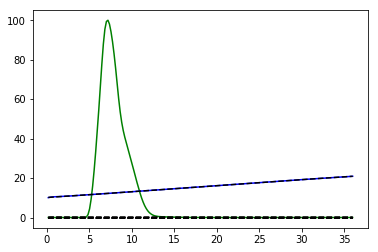

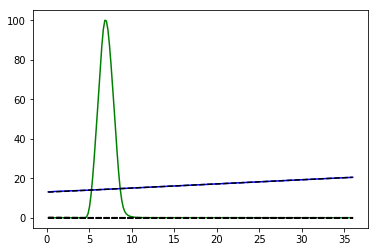

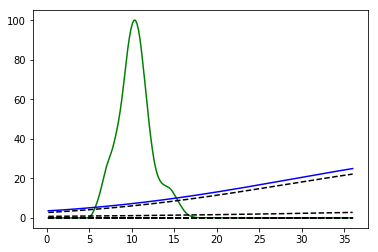

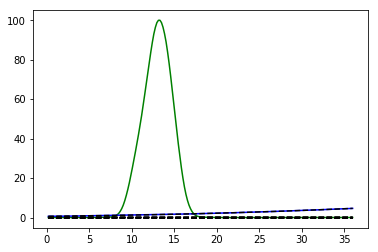

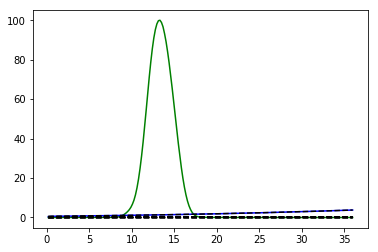

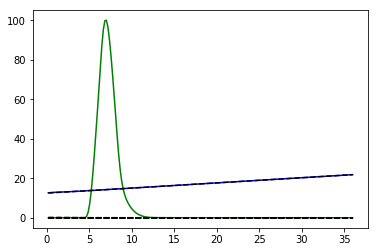

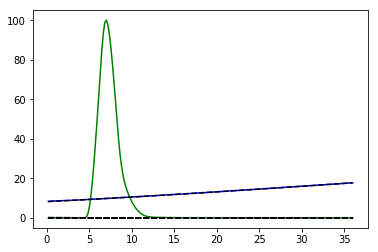

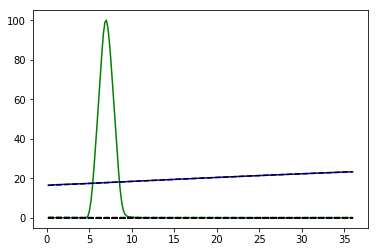

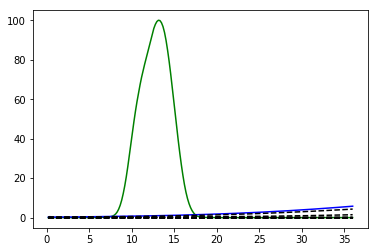

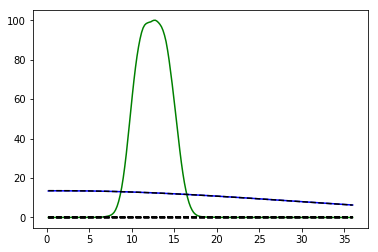

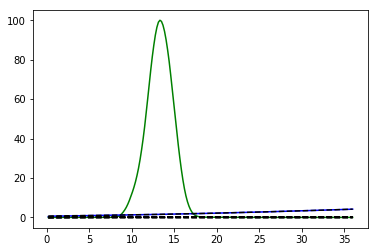

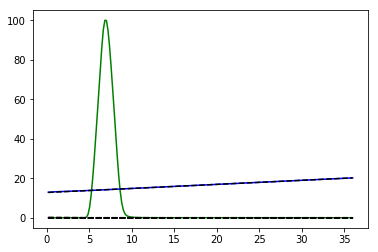

In [50]:
arrival_time = datadic[filename]
intenslist = []
predictlist = []
for i in datadic.keys():
    if i == filename:
        continue
    voltage = i
    intensities = datadic[voltage]
    intenslist.append(intensities)
    predictlist.append(model.predict(np.array(intensities).reshape(1,200)))
print(predictlist[1])
mixturelist = []
for i in predictlist:
    mixturelist.append(Combine_Distribution([Normal_Distribution(i[0][j],i[0][j + num],i[0][j + 2*num], x_range) for j in range(0, int(len(i[0]) / 3))]))
    
plotdic = {}
print(mixturelist[0].distributions[0])
for i in range(0, len(intenslist)):
    plt.plot(arrival_time, intenslist[i], 'g-')
    plt.plot(arrival_time, mixturelist[i].curve, 'b-')
    for j in range(0, len(mixturelist[i].distributions)):
        plt.plot(arrival_time, mixturelist[i].distributions[j].data, 'k--')
    plt.show()